<a href="https://colab.research.google.com/github/navyaboddapati/LLM--Detect-AI-Generated-Text/blob/main/LLM_Detect_AI_Generated_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# downloading necessary kaggle versions
!pip install kaggle

In [17]:
# using kaggle key value
import os
os.environ['KAGGLE_USERNAME'] = 'navyaboddapati'
os.environ['KAGGLE_KEY'] = '3d801ca7ef63201eb65ce89d7af7db3d'

In [18]:
# downloading data from kaggle competation
!kaggle competitions download -c llm-detect-ai-generated-text

llm-detect-ai-generated-text.zip: Skipping, found more recently modified local copy (use --force to force download)


In [19]:
# unziping the folder
!unzip llm-detect-ai-generated-text.zip

Archive:  llm-detect-ai-generated-text.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test_essays.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test_essays.csv         
replace train_essays.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train_prompts.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace train_prompts.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [20]:
import pandas as pd
from concurrent.futures import process
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import numpy as np
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk

In [21]:
# Loading the data
train_data = pd.read_csv('train_essays.csv')
test_data = pd.read_csv('test_essays.csv')

In [22]:
# Checking on the nature of datasets
print('Head train data : ')
print(train_data.head())
print('I\nnfo: ')
print(train_data.info())
print('\nDescribe data: ')
print(train_data.describe())

Head train data : 
         id  prompt_id                                               text  \
0  0059830c          0  Cars. Cars have been around since they became ...   
1  005db917          0  Transportation is a large necessity in most co...   
2  008f63e3          0  "America's love affair with it's vehicles seem...   
3  00940276          0  How often do you ride in a car? Do you drive a...   
4  00c39458          0  Cars are a wonderful thing. They are perhaps o...   

   generated  
0          0  
1          0  
2          0  
3          0  
4          0  
I
nfo: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
None

Describe data: 
       

In [23]:
# finding no. of records
num_records = len(train_data)
print(f'Number of Records: {num_records}')

Number of Records: 1378


In [24]:
# no. of null values in the data
null_counts = train_data.isnull().sum()
print(f'Number of Null Values:{null_counts}')

Number of Null Values:id           0
prompt_id    0
text         0
generated    0
dtype: int64


In [25]:
'''df1 = pd.read_csv('train_essays.csv')
df2 = pd.read_csv('train_prompts.csv')
df = pd.merge(df1,df2,)'''

"df1 = pd.read_csv('train_essays.csv')\ndf2 = pd.read_csv('train_prompts.csv')\ndf = pd.merge(df1,df2,)"

Generated 0: 1375 essays
Generated 1: 3 essays




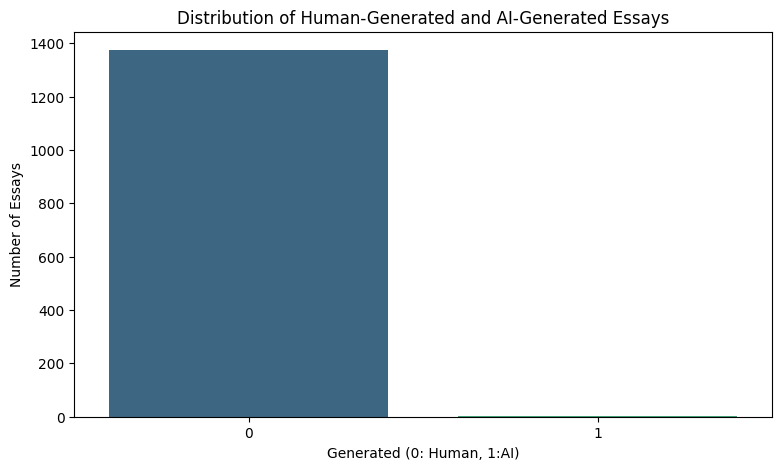

In [26]:
# checking for how many are human essays and AI generated essays
import matplotlib.pyplot as plt
import seaborn as sns

generated_counts = train_data['generated'].value_counts()

for value,count in generated_counts.items():
  print(f"Generated {value}: { count} essays")

plt.figure(figsize=(9,5))
sns.barplot(x=generated_counts.index, y=generated_counts.values, palette='viridis')
print("\n")
plt.title('Distribution of Human-Generated and AI-Generated Essays')
plt.xlabel('Generated (0: Human, 1:AI)')
plt.ylabel('Number of Essays')
plt.show()

In [27]:
# Splitting the data into train and valid
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# input value label text
X = train_data['text']

# output value label generated
y = train_data['generated']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [28]:
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk

# tokenizing the text
nltk.download('punkt')

tokenized_essays = [word_tokenize(essay.lower()) for essay in train_data['text']]

all_words = [word for essay_words in tokenized_essays for word in essay_words]

word_counts = Counter(all_words)

# Building the vocabulary

vocabulary = [word for word, count in word_counts.items() if count>=5]

# reversing the index
reverse_index = {word: idx for idx, word in enumerate(vocabulary)}

print("Vocabulary:" , vocabulary[:10])

# print("Reverse Index:" , reverse_index)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Vocabulary: ['cars', '.', 'have', 'been', 'around', 'since', 'they', 'became', 'famous', 'in']


In [29]:
# calculating total words
total_words = len(all_words)

#calculating word occurence probability
word_occurence_probability = {word: count/total_words for word, count in word_counts.items()}

print("Total words count: ", total_words)
# print("Word occurences probability: ",word_occurence_probability)

Total words count:  855744


In [30]:
# calculating conditional probabilities
def calculate_conditional_probabilities(data, target_class, vocabulary, word_index):
    class_data = data[data['generated'] == target_class]
    total_class_words = [word for essay in class_data['text'] for word in word_tokenize(essay.lower())]

    class_word_counts = Counter(total_class_words)

    conditional_probabilities = {word: class_word_counts[word]/len(total_class_words) for word in vocabulary}

    return  conditional_probabilities

    human_cond_prob = calculate_conditional_probabilities(train_data, 0, vocabulary, word_index)

    # print("Humand conditional Probability", human_cond_prob)

    llm_cond_prob = calculate_conditional_probabilities(train_data, 1, vocabulary, word_index)

    # print("LLM conditional Probability", llm_cond_prob)


In [31]:
from concurrent.futures import process
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import numpy as np

labels = train_data['generated'].values

processed_essays = [' '.join(essay) for essay in tokenized_essays]

# splitting data to train and development
X_train, X_dev, y_train, y_dev = train_test_split(processed_essays, labels, test_size =0.2, random_state = 42)

X_train_array = np.array(X_train)
X_dev_array = np.array(X_dev)

# vectorized train and development data
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_dev_vectorized = vectorizer.transform(X_dev)

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vectorized, y_train)

#printing accuracy of development set
dev_predictions = nb_classifier.predict(X_dev_vectorized)

accuracy = accuracy_score(y_dev, dev_predictions)
print(f"Accuracy on the Development set: {accuracy}")

# printing accuracy of training set
train_predictions = nb_classifier.predict(X_train_vectorized)

train_accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy on the Training set:",train_accuracy)



Accuracy on the Development set: 0.9963768115942029
Accuracy on the Training set: 0.9981851179673321


In [32]:
# taking different values of smoothing
alpha_values = [0.1, 0.5, 1.0]
accuracies = []

# finding accuracy for different values of alpha
for alpha in alpha_values:
    nb_classifier = MultinomialNB(alpha = alpha)
    nb_classifier.fit(X_train_vectorized, y_train)
    dev_predictions = nb_classifier.predict(X_dev_vectorized)
    accuracy = accuracy_score(y_dev, dev_predictions)
    accuracies.append(accuracy)
    print(f"Smoothing (alpha={alpha}): Accuracy on Development set: {accuracy}")

# predicting top 10 words of the class
feature_names = np.array(vectorizer.get_feature_names_out())
top_predictive_words = {}

for i, class_label in enumerate(nb_classifier.classes_):
    class_probs = nb_classifier.feature_log_prob_[i]
    top_word_indices = np.argsort(class_probs)[::-1][:10]
    top_words = [feature_names[idx] for idx in top_word_indices]
    top_predictive_words[class_label] = top_words
    print(f"Top 10 words predicting class '{class_label}': {top_words}")

# finding best alpha value
optimal_alpha = alpha_values[np.argmax(accuracies)]
print(f"Optimal Smoothing Parameter (aplha): {optimal_alpha}")

final_nb_classifier = MultinomialNB(alpha=optimal_alpha)
final_nb_classifier.fit(X_train_vectorized, y_train)

# Process the test essays
tokenized_test_essays = [word_tokenize(essay.lower()) for essay in test_data['text']]
processed_test_essays = [' '.join(essay) for essay in tokenized_test_essays]

X_test_vectorized = vectorizer.transform(processed_test_essays)

# Make predictions on the test dataset
final_test_predictions = final_nb_classifier.predict(X_test_vectorized)

# Prepared submission DataFrame
submission_df = pd.DataFrame({'id': test_data['id'], 'generated': final_test_predictions})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('final_submission.csv', index=False)




Smoothing (alpha=0.1): Accuracy on Development set: 0.9963768115942029
Smoothing (alpha=0.5): Accuracy on Development set: 0.9963768115942029
Smoothing (alpha=1.0): Accuracy on Development set: 0.9963768115942029
Top 10 words predicting class '0': ['the', 'to', 'of', 'and', 'in', 'is', 'electoral', 'that', 'car', 'vote']
Top 10 words predicting class '1': ['the', 'votes', 'electoral', 'state', 'nationally', 'vote', 'of', 'candidate', 'college', 'for']
Optimal Smoothing Parameter (aplha): 0.1



**References**
[1].	LLM - Detect AI Generated Text | Kaggle
[2].	Bird, Steven, Edward Loper and Ewan Klein (2009), Natural Language Processing with Python. https://www.nltk.org/
[3].	https://www.nltk.org/api/nltk.html
[4].	https://link.springer.com/article/10.1007/s42979-021-00480-4
[5].	https://kavita-ganesan.com/practical-text-classification-best-practices/
[6].	https://www.machinelearningplus.com/predictive-modeling/how-naive-bayes-algorithm-works-with-example-and-full-code/
[7].	https://scikit-learn.org/stable/modules/naive_bayes.html
[8].	https://www.freecodecamp.org/news/how-naive-bayes-classifiers-work/
[9].	The Naive Bayes classifier. The Naive Bayes algorithm is explained… | by Ritwick Roy | Towards Data Science
[10].	https://scikit-learn.org/stable/modules/naive_bayes.html
[11].	https://pubs.aip.org/aip/acp/article/2566/1/030004/2829788/Classification-data-mining-with-Laplacian
[12].	https://cs229.stanford.edu/proj2020spr/report/Wu_Shin.pdf
[13].	https://arxiv.org/pdf/2004.03705
[14]. https://link.springer.com/chapter/10.1007/978-3-030-84522-3_32

